In [429]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 10, 7

from importlib import reload
import ast
import json

import plotting
import toolbox as tb
import feature_creation

# reload modules
tb = reload(tb)
plotting = reload(plotting)
feature_creation = reload(feature_creation)

from plotting import Plotter

from feature_creation import YNormal, featurize, my_get_dummies

# ignore warnings
import warnings
warnings.filterwarnings(action="ignore")

Load data.

In [373]:
train_data = pd.read_csv('dataset/train.csv')
validation = pd.read_csv('dataset/validation.csv')
test_data = pd.read_csv('dataset/test.csv')

train_data.shape, validation.shape, test_data.shape

((2250, 24), (750, 24), (4398, 22))

In [374]:
train_data

,Unnamed: 0,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,750,751,NaN,30000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0332047,en,Fever Pitch,When relaxed and charming Ben Wrightman meets ...,...,4/6/05,103.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,A Comedy About The Game of Love.,Fever Pitch,"[{'id': 1480, 'name': 'baseball'}, {'id': 3419...","[{'cast_id': 1, 'character': 'Lindsey Meeks', ...","[{'credit_id': '52fe443f9251416c7502df99', 'de...",50451307
1,751,752,"[{'id': 5039, 'name': 'Rambo Collection', 'pos...",50000000,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",http://www.rambofilm.com/,tt0462499,en,Rambo,When governments fail to act on behalf of capt...,...,1/24/08,92.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Heroes never die... They just reload.,Rambo,"[{'id': 440, 'name': 'missionary'}, {'id': 126...","[{'cast_id': 12, 'character': 'John Rambo', 'c...","[{'credit_id': '55c8e0ff92514177c9000085', 'de...",113244290
2,752,753,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 99, 'nam...",NaN,tt0175844,en,Lenny Bruce: Swear to Tell the Truth,"In 1948, Lenny Bruce was just another comic wh...",...,10/21/98,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A documentary about the comic who invented con...,Lenny Bruce: Swear to Tell the Truth,"[{'id': 3485, 'name': 'comedian'}, {'id': 5565...","[{'cast_id': 1, 'character': 'Himself / Narrat...","[{'credit_id': '52fe4a19c3a36847f81b92ff', 'de...",21350
3,753,754,"[{'id': 59586, 'name': 'The Blue Lagoon collec...",4500000,"[{'id': 10749, 'name': 'Romance'}, {'id': 12, ...",NaN,tt0080453,en,The Blue Lagoon,Two small children and a ship's cook survive a...,...,7/5/80,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A sensuous story of natural love.,The Blue Lagoon,"[{'id': 566, 'name': 'sexual identity'}, {'id'...","[{'cast_id': 7, 'character': 'Emmeline', 'cred...","[{'credit_id': '52fe4418c3a36847f8081fa3', 'de...",58853106
4,754,755,NaN,6000000,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",http://www.paramountvantage.com/virginsuicides...,tt0159097,en,The Virgin Suicides,A group of male friends become obsessed with f...,...,4/21/99,97.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"Beautiful, mysterious, haunting, invariably fa...",The Virgin Suicides,"[{'id': 933, 'name': 'michigan'}, {'id': 1228,...","[{'cast_id': 17, 'character': 'Mr. Lisbon', 'c...","[{'credit_id': '52fe42f8c3a36847f80308d5', 'de...",10409377
5,755,756,NaN,0,"[{'id': 16, 'name': 'Animation'}, {'id': 10402...",NaN,tt0082009,en,American Pop,American Pop is an American animated film that...,...,2/13/81,96.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,"All those years, all those dreams, all those s...",American Pop,"[{'id': 637, 'name': 'pop'}, {'id': 1416, 'nam...","[{'cast_id': 3, 'character': 'Tony Belinksy / ...","[{'credit_id': '52fe45cfc3a368484e070365', 'de...",6000000
6,756,757,NaN,0,"[{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...",NaN,tt0108656,cn,重案組,A special agent assigned to protect a wealthy ...,...,6/24/93,103.0,"[{'iso_639_1': 'cn', 'name': '广州话 / 廣州話'}, {'i...",Released,The world's toughest city needs more than an a...,Crime Story,"[{'id': 1562, 'name': 'hostage'}, {'id': 1930,...","[{'cast_id': 2, 'character': 'Inspector Eddie ...","[{'credit_id': '58bac867c3a368666b02027b', 'de...",194720
7,757,758,NaN,80000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,tt0369436,en,Four Christmases,Brad and Kate have made something of an art fo...,...,11/26/08,88.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"His father, her mother, his mother and her fat...",Four Christmases,"[{'id': 65, 'name': 'holiday'}, {'id': 9799, '...","[{'cast_id': 2, 'character': 'Brad McVie', 'cr...","[{'credit_id': '52fe44c89251416c75040bed', 'de...",1637

In [375]:
train_data.columns

Index(['Unnamed: 0', 'id', 'belongs_to_collection', 'budget', 'genres',
       'homepage', 'imdb_id', 'original_language', 'original_title',
       'overview', 'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue'],
      dtype='object')

Make a copy of *train_data* and *test_data* for not modifing them.

In [376]:
train_df = train_data.copy()
test_df = test_data.copy()

# checking the ids
np.any((id(train_df) == id(train_data)) and (id(test_df) == id(test_data)))

False

### Preprocess, visualize and analyze data.

### Analyzing the data.

Initialize **Plotter** for plotting with less typing.

In [377]:
plotter = Plotter(colors=['red', 'blue', 'green', 'orange'])

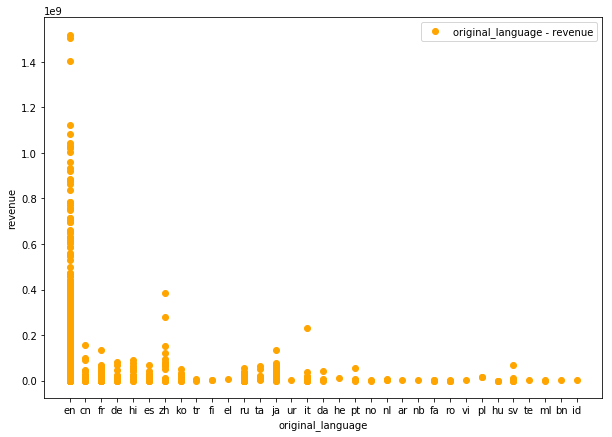

In [378]:
plotter.relationship(train_df, 'original_language', 'revenue', color='orange')

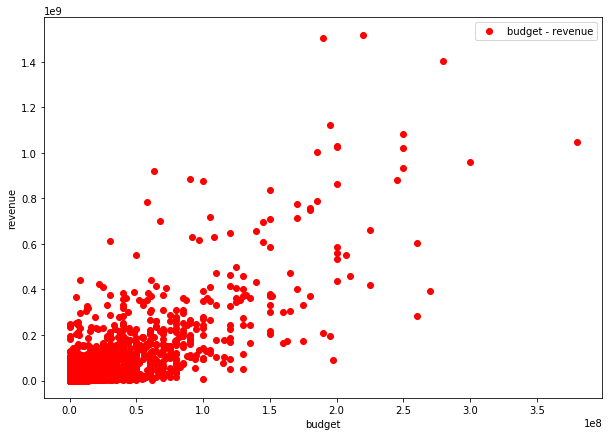

In [379]:
plotter.relationship(train_df, 'budget', 'revenue', color='red')

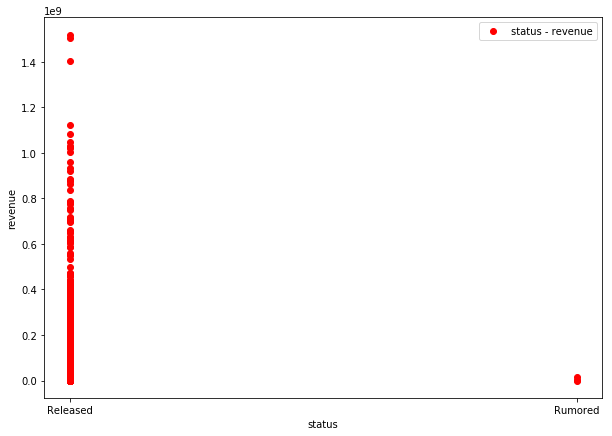

In [380]:
plotter.relationship(train_df, 'status', 'revenue', color='red')

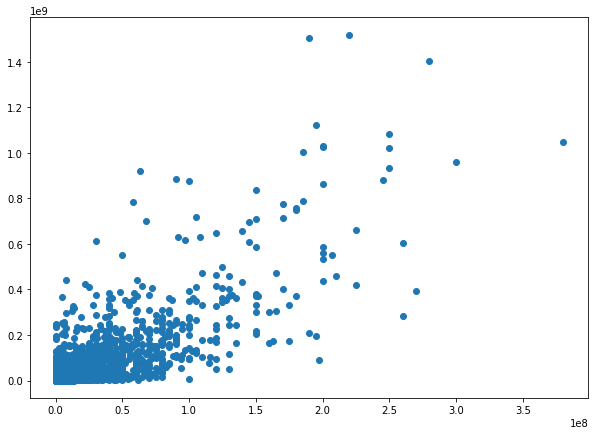

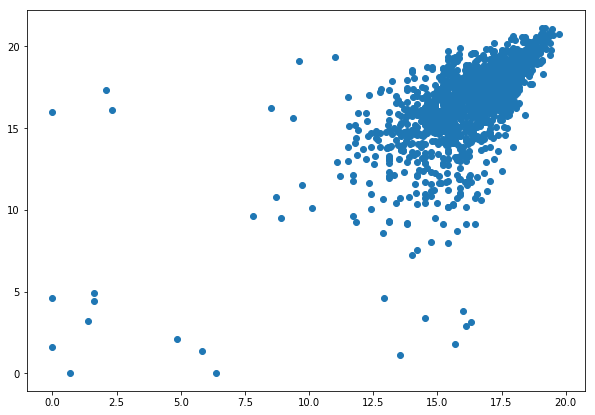

In [381]:
plt.scatter(train_df['budget'], train_df['revenue'])
plt.show()

plt.scatter(np.log(train_df['budget']), np.log(train_df['revenue']))
plt.show()

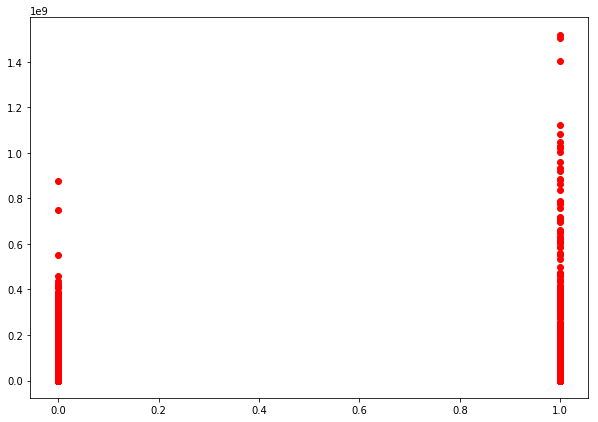

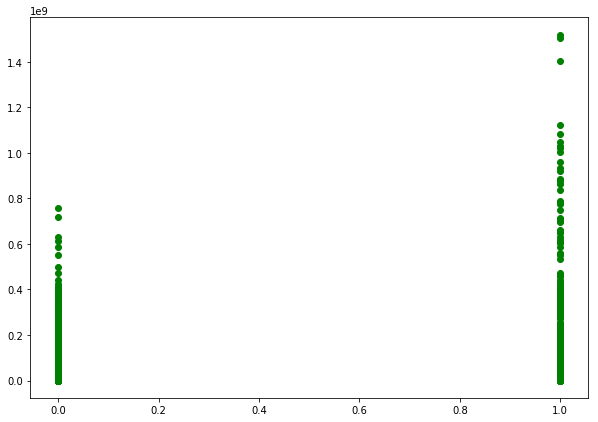

In [382]:
plt.scatter(np.array(pd.notna(train_df.homepage), dtype=int), train_df.revenue, color='red')
plt.show()
plt.scatter(np.array(pd.notna(train_df.belongs_to_collection), dtype=int), train_df.revenue, color='green');

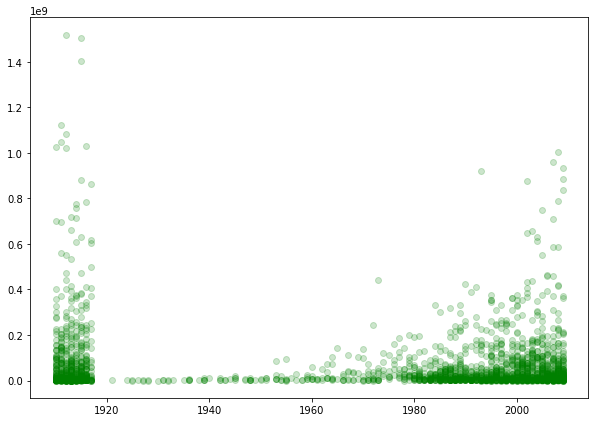

In [383]:
years = np.array([f'20{date[-2:]}' if date[-2:].startswith('0') else f'19{date[-2:]}' 
                  for date in train_data['release_date'].values], dtype=np.int)

plt.scatter(years, train_df.revenue, alpha=0.2, color='green');

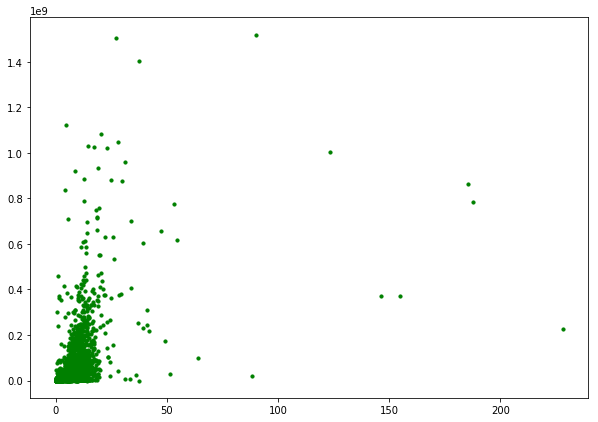

In [384]:
plt.scatter(train_df.popularity, train_df.revenue, color='green', s=10);

In [385]:
json_crew = tb.json_to_dict(train_df['crew'].fillna(''))
crew_gender = np.array(tb.get_json_features(json_crew, 'gender', train_df['revenue']))

crew_gender

array([[            0, 4258987872473],
       [            2, 2052450812370],
       [            1,  546217550059]])

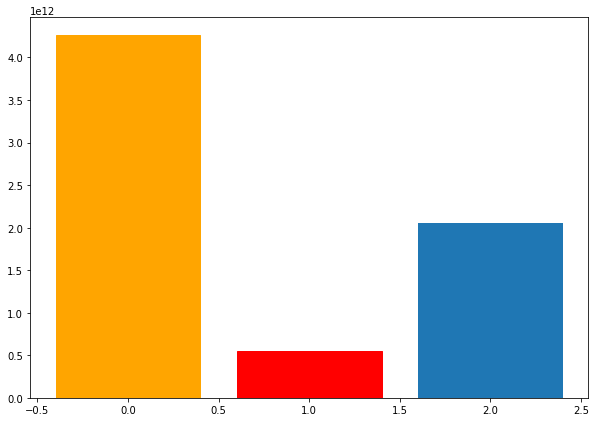

In [386]:
bar_list = plt.bar(crew_gender[:, 0], crew_gender[:, 1]);
bar_list[0].set_color('orange')
bar_list[2].set_color('red')

#### Observe json features.

Pick one column, and row and see what kind of keys this particular **json** has.
In this case *id*, *name*, *poster_path* and *backdrop_path*.

In [387]:
train_df['belongs_to_collection'][1]

"[{'id': 5039, 'name': 'Rambo Collection', 'poster_path': '/feGOEOVrOLyjtEnVa88rQLgD3XY.jpg', 'backdrop_path': '/Yt2ZxbJv2HM842B6FNMr59Vhyb.jpg'}]"

#### Because all json columns are simular(every column row is a list with *json* or *dict*) I created *get_json_features* function that will help to process data easier.

*Note that the function is documented, so you can read what is takes and returns.*

In the case of *belongs_to_collection* column we can know all unique *names* that when apper in *belongs_to_collection*, have high *revenue*. Basicaly this will show that in *belongs_to_collection*'s 
*json* file, in this case **James Bond Collection**, **Transformers Collection** are importand features. Note that as the list goes on the features became less and less important.

In [388]:
dict_features = tb.json_to_dict(train_df['belongs_to_collection'].fillna(0))
json_features = tb.get_json_features(dict_features, 
                                     'name', train_df['revenue'])

json_features[:5]

[('James Bond Collection', 3964664449),
 ('Transformers Collection', 3274696147),
 ('The Avengers Collection', 2924961604),
 ('Pirates of the Caribbean Collection', 2661725026),
 ('The Dark Knight Collection', 2463716216)]

We can do the same for *genres* and other columns. First see what kind of *json* keys it has and then find the most relevant keys to use to get the important features. 

In this case *name* is a relevant key, so we take that.

In [389]:
train_df['genres'].iat[0]

"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}]"

In [390]:
dict_features = tb.json_to_dict(train_df['genres'].fillna(0))
json_features = tb.get_json_features(dict_features,
                                          'name', train_df['revenue'])

json_features[:5]

[('Action', 64508876116),
 ('Adventure', 59300673110),
 ('Drama', 51785811560),
 ('Comedy', 45082571997),
 ('Thriller', 40206829535)]

In [391]:
train_df['spoken_languages'][0]

"[{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'pl', 'name': 'Polski'}, {'iso_639_1': 'pt', 'name': 'Português'}]"

In [392]:
dict_features = tb.json_to_dict(train_df['spoken_languages'].fillna(0))
json_features = tb.get_json_features(dict_features,
                                          'name', train_df['revenue'])

json_features[:8]

[('English', 143982168270),
 ('Español', 15831002978),
 ('Français', 14680505015),
 ('Deutsch', 9271071823),
 ('Italiano', 7616111658),
 ('Pусский', 7570870191),
 ('普通话', 5610380298),
 ('日本語', 3363570933)]

In [393]:
train_df['Keywords'][0]

"[{'id': 1480, 'name': 'baseball'}, {'id': 3419, 'name': 'fanatic'}, {'id': 5625, 'name': 'relationship problems'}, {'id': 6075, 'name': 'sport'}, {'id': 10508, 'name': 'teacher'}, {'id': 155725, 'name': 'red sox'}, {'id': 155726, 'name': 'fenway park'}]"

In [394]:
dict_features = tb.json_to_dict(train_df['Keywords'].fillna(0))
json_features = tb.get_json_features(dict_features,
                                          'name', train_df['revenue'])

json_features[:8]

[('duringcreditsstinger', 20182381809),
 ('aftercreditsstinger', 14767874995),
 ('superhero', 12133112476),
 ('sequel', 11829417536),
 ('3d', 11399169303),
 ('based on comic', 10676394118),
 ('based on novel', 9047438791),
 ('dystopia', 7693155010)]

In [395]:
train_df['cast'][0][:202]

"[{'cast_id': 1, 'character': 'Lindsey Meeks', 'credit_id': '52fe443f9251416c7502df43', 'gender': 1, 'id': 69597, 'name': 'Drew Barrymore', 'order': 0, 'profile_path': '/y8GKPHsBXVGIGBdDzdNxjm0IbKF.jpg'}"

In [396]:
dict_features = tb.json_to_dict(train_df['cast'].fillna(0))
json_features = tb.get_json_features(dict_features,
                                          'name', train_df['revenue'])

f'name', json_features[:10]

('name',
 [('Samuel L. Jackson', 7316018488),
  ('Stan Lee', 6518945480),
  ('Frank Welker', 4982007905),
  ('Jeremy Renner', 4643068839),
  ('Johnny Depp', 4586705934),
  ('Tyrese Gibson', 4410059212),
  ('Judi Dench', 4317926509),
  ('Stellan Skarsg√•rd', 4149023692),
  ('John Turturro', 4140831341),
  ('Shia LaBeouf', 4090590413)])

In [397]:
title_mask = train_df.title == train_df.original_title

print(title_mask.sum(), (~title_mask).sum())
train_df.revenue[title_mask].mean(), train_df.revenue[~title_mask].mean()

1979 271


(72861379.31581607, 20299293.45387454)

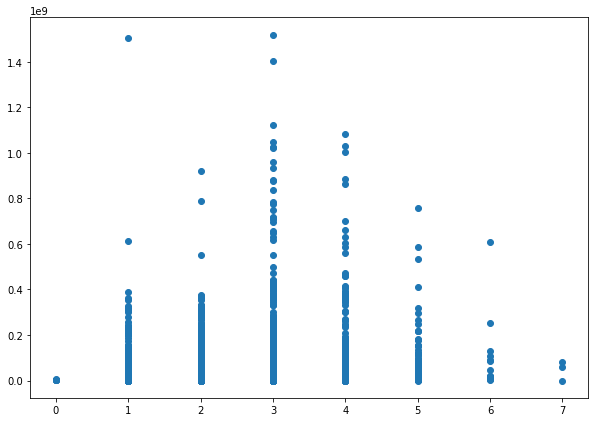

In [398]:
# features that have more json, key values, may be more important
genre_info = [len(genre) for _, genre in tb.json_to_dict(train_df['genres'].fillna('')).iteritems()]

plt.scatter(genre_info, train_df.revenue);

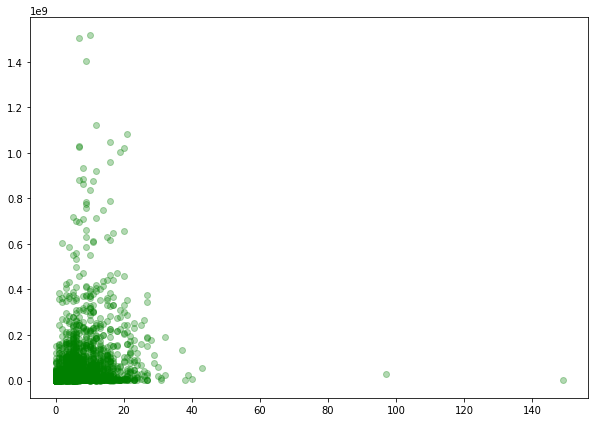

In [399]:
genre_info = [len(genre) for _, genre in tb.json_to_dict(train_df['Keywords'].fillna('')).iteritems()]

plt.scatter(genre_info, train_df.revenue, color='green', alpha=0.3);

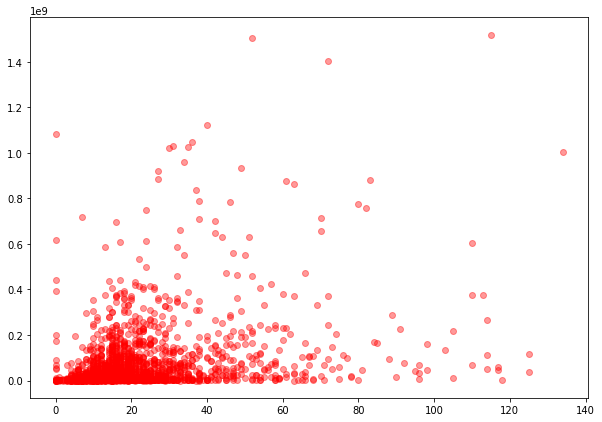

In [400]:
genre_info = [len(genre) for _, genre in tb.json_to_dict(train_df['cast'].fillna('')).iteritems()]

plt.scatter(genre_info, train_df.revenue, color='red', alpha=0.4);

**Featurize** function for building features.

In [408]:
#valid_y: targets of validation
valid_y = validation["revenue"]

#train_feat: featurize's train data without target
#valid_feat: featurize's validation without target
#train_y: targets of train data?
train_feat, valid_feat, train_y = featurize(train_df, validation)

all_train = pd.read_csv('kaggleDataset/train.csv')
#all_train_feat: featurized train_data + validation
#test_feat: featurized test_data
#target: train_y + valid_y
all_train_feat, test_feat, target = featurize(all_train, test_df)

In [409]:
train_feat.columns

Index(['genders_0_crew', 'genders_1_crew', 'genders_2_crew', 'is_from_coll',
       'not_from_coll', 'budget', 'popularity', 'runtime', 'is_tagline',
       'no_tagline', 'is_en', 'not_en', 'is_homepage', 'no_homepage',
       'is_date', 'not_date', 'is_same_title', 'not_same_title',
       'genres_feature_len', 'cast_feature_len', 'Action', 'Adventure',
       'Drama', 'Comedy', 'Thriller', 'duringcreditsstinger',
       'aftercreditsstinger', 'superhero', 'sequel', '3d', 'Samuel L. Jackson',
       'Stan Lee', 'Frank Welker', 'Jeremy Renner', 'Johnny Depp', 'English',
       'Español', 'Français', 'Deutsch'],
      dtype='object')

In [410]:
train_feat.head()

,genders_0_crew,genders_1_crew,genders_2_crew,is_from_coll,not_from_coll,budget,popularity,runtime,is_tagline,no_tagline,...,3d,Samuel L. Jackson,Stan Lee,Frank Welker,Jeremy Renner,Johnny Depp,English,Español,Français,Deutsch
0,3,7,16,1,0,0.201714,-0.142863,-0.219963,1,0,...,0,0,0,0,0,0,1,0,0,0
1,7,1,24,1,0,0.741873,0.119984,-0.718172,1,0,...,0,0,0,0,0,0,1,0,0,0
2,3,0,0,1,0,-0.608526,-0.669556,-0.355838,1,0,...,0,0,0,0,0,0,1,0,0,0
3,1,0,5,1,0,-0.48699,0.257378,-0.174671,1,0,...,0,0,0,0,0,0,1,0,0,0
4,3,8,8,1,0,-0.446478,0.168714,-0.491713,1,0,...,0,0,0,0,0,0,1,0,0,0


# Train models and measure validation.

Choose the best model with root mean squared log error function and predict *test* data.

## CatBoostRegressor

In [430]:
from catboost import CatBoostRegressor

cat = CatBoostRegressor(iterations=100000,
                            learning_rate=0.004,
                            depth=5,
                            eval_metric='RMSE',
                            bagging_temperature = 0.2,
                            metric_period = None,
                            early_stopping_rounds=200
                        )

cat, cat_score = tb.cross_validation(cat, train_feat.values, train_y.values.ravel(), 
                                          eval_set=(valid_feat, valid_y), 
                                          use_best_model=True, 
                                          verbose=False)

cat, cat_score

(<catboost.core.CatBoostRegressor at 0x1a77aaecc0>, 0.06705220248836274)

In [431]:
cat_pred = cat.predict(valid_feat.values)
tb.root_mean_squared_log_error(np.exp(cat_pred), valid_y.values.ravel())

(2.3697457693136865, 2.3697457693136865)

## RidgeCV

In [416]:
from sklearn.linear_model import RidgeCV

best_ridge_reg_model, ridge_reg_loss = tb.cross_validation(RidgeCV(), 
                                                           train_feat.values, train_y.values.ravel())

best_ridge_reg_model, ridge_reg_loss

(RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=None, fit_intercept=True,
     gcv_mode=None, normalize=False, scoring=None, store_cv_values=False),
 0.07987150826700282)

In [417]:
ridge_reg_pred = best_ridge_reg_model.predict(valid_feat.values)
tb.root_mean_squared_log_error(np.exp(ridge_reg_pred), valid_y.values.ravel())

(2.6112725369803607, 2.6112725369803607)

## RandomForestRegressor

In [422]:
from sklearn.ensemble import RandomForestRegressor

best_random_forest, forest_loss = tb.cross_validation(RandomForestRegressor(10), 
                                                     train_feat.values, train_y.values.ravel())

best_random_forest, forest_loss

(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0, warm_start=False),
 0.07550848786111973)

In [423]:
forest_pred = best_random_forest.predict(valid_feat.values)
tb.root_mean_squared_log_error(np.exp(forest_pred), valid_y.values.ravel())

(2.493907851567502, 2.493907851567502)

The best model is CatBoostRegressor

In [ ]:
# pred = cat.predict(test_feat)
# np.exp(pred)

In [439]:
# tb.save_as_csv(test_data['id'], np.exp(pred))